In [1]:
from keras.layers import Dense
from keras.models import Sequential   # funktioniert nur mit Tensorflow 1.13.1 und nicht mit der neuesten 2.0.0-alpha0 version
from keras.callbacks import EarlyStopping
from keras.preprocessing.sequence import TimeseriesGenerator
import pandas as pd
from datetime import date
import matplotlib.pyplot as plt



Using TensorFlow backend.


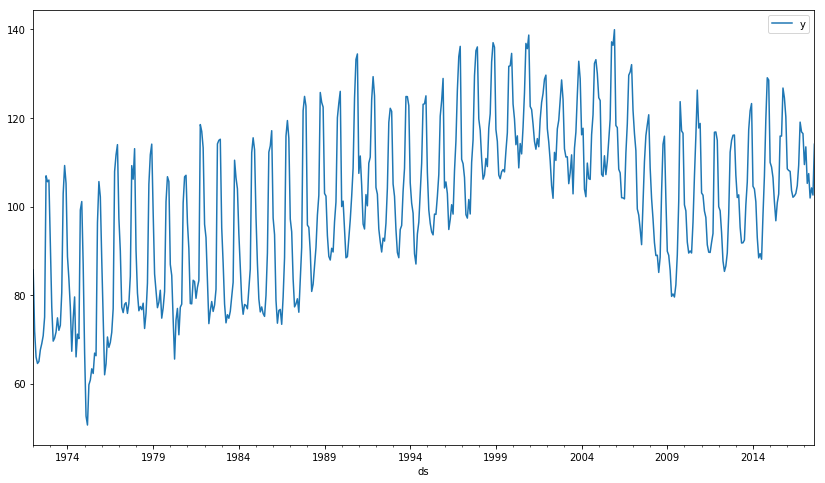

In [2]:
%run setup_workspace.ipynb 

In [3]:
data = candy_production
data.head()

ds        y
0 1972-01-01  85.6945
1 1972-02-01  71.8200
2 1972-03-01  66.0229
3 1972-04-01  64.5645
4 1972-05-01  65.0100

# Creating a Neural Network model

## 1. Train-test-validation-split

In [4]:
split_date = pd.Timestamp(date(2014,10,1))
split_date2 = pd.Timestamp(date(2015,10,1))
min_start = None
max_end = None
train = data[data.ds < split_date]
if min_start is not None:
    train = train[train['ds'] > min_start]
valid = data[(data.ds > split_date) & (data.ds < split_date2)]
test = data[data.ds > split_date2]

In [5]:
%%time
input_len = 3
train_generator = TimeseriesGenerator(train.y.values, train.y.values, length=input_len, batch_size=1)
test_generator = TimeseriesGenerator(test.y.values, test.y.values, length=input_len, batch_size=1)
valid_generator = TimeseriesGenerator(valid.y.values, valid.y.values, length=input_len, batch_size=1)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 355 µs


In [6]:
train[0:6]

ds        y
0 1972-01-01  85.6945
1 1972-02-01  71.8200
2 1972-03-01  66.0229
3 1972-04-01  64.5645
4 1972-05-01  65.0100
5 1972-06-01  67.6467

In [7]:
train_generator[0]

(array([[85.6945, 71.82  , 66.0229]]), array([64.5645]))

## 2. Model training

In [8]:
%%time
model = Sequential()
model.add(Dense(50, activation='relu', input_dim=input_len))
model.add(Dense(1))
model.compile(optimizer='adadelta', loss='mae')
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                200       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 251
Trainable params: 251
Non-trainable params: 0
_________________________________________________________________
CPU times: user 68 ms, sys: 4 ms, total: 72 ms
Wall time: 66.9 ms


In [9]:
%%time
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')

history =  model.fit_generator(train_generator, steps_per_epoch=5, epochs=50, verbose=0, 
                               callbacks=[earlyStopping], 
                               validation_data=valid_generator)

Instructions for updating:
Use tf.cast instead.
CPU times: user 1.7 s, sys: 256 ms, total: 1.96 s
Wall time: 5.37 s


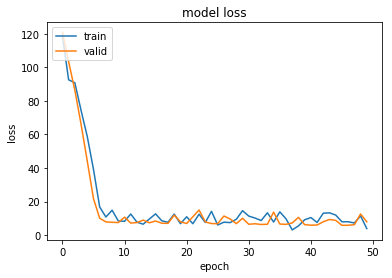

In [10]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

## 3. Forecast

In [11]:
prediction = model.predict_generator(test_generator)

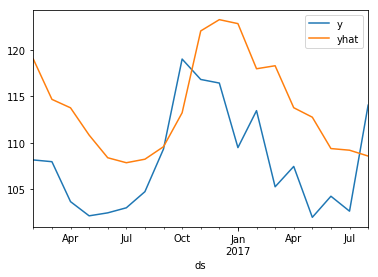

In [12]:
tmp = test.copy().iloc[input_len:,:]
tmp['yhat'] = prediction
tmp.set_index('ds', drop=True).plot()

## 4. Evaluation

In [13]:
error = mean_absolute_percentage_error(test.y[input_len:].values, prediction)
print('MAPE:%0.2f%%'%error)

MAPE:7.39%


## 5. Train several times

In [14]:
# %%time
# mape_results = []
# for i in range(0,30):
#     model = Sequential()
#     model.add(Dense(50, activation='relu', input_dim=input_len))
#     model.add(Dense(1))
#     model.compile(optimizer='adadelta', loss='mae')
    
#     earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')

#     history =  model.fit_generator(train_generator, steps_per_epoch=5, epochs=50, verbose=0, 
#                                callbacks=[earlyStopping], 
#                                validation_data=valid_generator)
    
#     prediction = model.predict_generator(test_generator)
    
#     error = mean_absolute_percentage_error(test.y[input_len:].values, prediction)
#     print('MAPE:%0.2f%%'%error)
#     mape_results.append(error)

# print(np.mean(mape_results))

MAPE:7.90%
MAPE:6.50%
MAPE:5.58%
MAPE:10.99%
MAPE:7.57%
MAPE:11.17%
MAPE:7.80%
MAPE:9.88%
MAPE:9.17%
MAPE:5.42%
MAPE:5.27%
MAPE:5.39%
MAPE:5.39%
MAPE:11.77%
MAPE:5.83%
MAPE:8.58%
MAPE:7.42%
MAPE:5.66%
MAPE:5.38%
MAPE:9.47%
MAPE:7.37%
MAPE:11.04%
MAPE:5.68%
MAPE:6.10%
MAPE:7.02%
MAPE:6.76%
MAPE:5.42%
MAPE:11.33%
MAPE:8.93%
MAPE:7.27%
7.634969815830742
CPU times: user 1min 8s, sys: 6.05 s, total: 1min 14s
Wall time: 2min 45s
